# Preliminaries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
# plt.rcParams['text.usetex'] = True  # nice but slow

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel3
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel3Jit
from dissipationtheory.dissipation17e import pointprobeCobject

In [3]:
from dissipationtheory.dissipation5 import ExptSweepConductivity
from dissipationtheory.dissipation5 import latex_float

In [4]:
THIS = 'dissipation-theory--Study-73--'
figs = {}
obj = {}

# Cantilever

Keep the cantilever parameters the same as in Study 41, so we can compare plots.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(2000, 'nm'))

Set the tip-sample separation and modulation frequency used below.

In [6]:
h = ureg.Quantity(73, 'nm')
wm = 1.0e5

# Type 3 sample

## High conductivity

In [7]:
sigma = ureg.Quantity(1E-2, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

In [8]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.023    +2.323941e-02
   Delta f dc [Hz]      -0.722    -7.223989e-01
   Delta f ac [Hz]      -0.361    -3.611989e-01
--------------------------------------------------


## Low conductivity

In [9]:
sigma = ureg.Quantity(1E-9, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

In [10]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.026    +2.605338e-02
   Delta f dc [Hz]      -0.656    -6.555607e-01
   Delta f ac [Hz]      -0.328    -3.277784e-01
--------------------------------------------------


## Compute the two $\Delta f_{\mathrm{DC}}$ limits

A function to compute the two bounds for $\Delta f_{\mathrm{DC}}$

In [11]:
def dfdclims(obj):
    
    es = obj.sample.epsilon_s
    eta = (es - 1)/(es + 1)
    
    fc = ureg.Quantity(obj.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(obj.sample.cantilever.k_c, 'N/m')
    
    R = ureg.Quantity(obj.sample.cantilever.R, 'm')
    V = ureg.Quantity(obj.sample.cantilever.V_ts, 'V')
    q0 = ureg.Quantity(4 * np.pi * epsilon0 * R * V, 'C')

    zc = ureg.Quantity(obj.info['r [nm]'] + obj.info['h [nm]'], 'nm')
    
    dfdc = -(fc * q0**2)/(4 * np.pi * epsilon0 * kc * 4 * zc**3)
    
    return np.array([dfdc.to('Hz').magnitude,
                     eta.real * dfdc.to('Hz').magnitude])

In [12]:
dfdclims(obj['pt 3'])

array([-0.72454716, -0.65554892])

We see that $\Delta f_{\mathrm{DC}}$ does indeed lie between these two bounds.

## $\Delta f_{\mathrm{DC}}$ versus charge density $\rho$

In [13]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1e0),
        num=200), 'S/m')

mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

In [14]:
gamma__array = np.zeros(len(sigma__array))
dfdc__array = np.zeros(len(sigma__array))

for index, (sigma, rho) in enumerate(zip(sigma__array, rho__array)):

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    obj['pt 3'] = pointprobeCobject(sample3_jit)
    obj['pt 3'].addsphere(h)
    obj['pt 3'].set_breakpoints(15)
    obj['pt 3'].properties(0.)
    
    gamma__array[index] = obj['pt 3'].results['gamma [pN s/m]']
    dfdc__array[index] = obj['pt 3'].results['Delta f dc [Hz]']

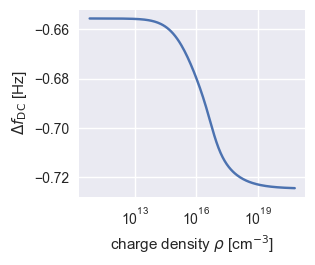

In [126]:
with plt.style.context('seaborn-v0_8'):

    figs['01'] = plt.figure(figsize=(3.25, 2.75))
    plt.semilogx(rho__array.to('1/cm^3').magnitude, dfdc__array)
    plt.xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    plt.ylabel('$\Delta f_{\mathrm{DC}}$ [Hz]')
    plt.tight_layout()
    plt.show()

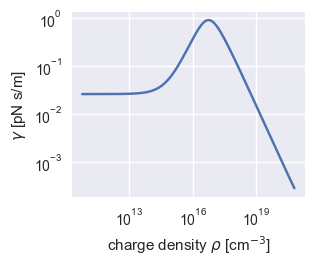

In [131]:
with plt.style.context('seaborn-v0_8'):

    figs['02'] = plt.figure(figsize=(3.25, 2.75))
    plt.loglog(rho__array.to('1/cm^3').magnitude, gamma__array)
    plt.xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    plt.ylabel('$\gamma$ [pN s/m]')
    plt.tight_layout()
    plt.show()

This plot looks reasonable.

## Frequency dependence

Compute the expected limiting values at low and high $\omega_{\mathrm{m}}$.

In [17]:
def dfaclims(obj):
    
    es = obj.sample.epsilon_s
    eta = (es - 1)/(es + 1)
    
    fc = ureg.Quantity(obj.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(obj.sample.cantilever.k_c, 'N/m')
    
    R = ureg.Quantity(obj.sample.cantilever.R, 'm')
    V = ureg.Quantity(obj.sample.cantilever.V_ts, 'V')
    q0 = ureg.Quantity(4 * np.pi * epsilon0 * R * V, 'C')

    zc = ureg.Quantity(obj.info['r [nm]'] + obj.info['h [nm]'], 'nm')
    
    dfdc = -(fc * q0**2)/(4 * np.pi * epsilon0 * kc * 4 * zc**3)
    dfac = -(fc * q0**2 * eta.real)/(8 * np.pi * epsilon0 * kc * 4 * zc**3)
    
    return np.array([dfdc.to('Hz').magnitude/2,
                     dfac.to('Hz').magnitude])

Now set up the sample again, printing out $\omega_0$.

In [18]:
sigma = ureg.Quantity(1E-5, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

print(f"omega0 = {sample3_jit.omega0/sample3_jit.epsilon_s.real:0.2e} Hz")

omega0 = 5.65e+04 Hz


Low modulation frequency

In [19]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.248    +2.477173e-01
   Delta f dc [Hz]      -0.676    -6.755329e-01
   Delta f ac [Hz]      -0.335    -3.348030e-01
--------------------------------------------------


High modulation frequency

In [20]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(1e7)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.248    +2.477173e-01
   Delta f dc [Hz]      -0.676    -6.755329e-01
   Delta f ac [Hz]      -0.328    -3.278022e-01
--------------------------------------------------


## Representative BLDS specta

In [21]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=100), 'Hz')

In [22]:
def blds(omega_m__array, rho, mu):

    rho = ureg.Quantity(rho, '1/cm^3')
    mu = ureg.Quantity(mu, 'm^2/(V s)') 
    sigma = (qe * mu * rho).to('S/m')

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    print(f"omega0 = {sample3_jit.omega0/sample3_jit.epsilon_s.real:0.2e} Hz")

    dfac__array = np.zeros(len(omega_m__array))

    obj['pt 3'] = pointprobeCobject(sample3_jit)
    obj['pt 3'].addsphere(h)
    obj['pt 3'].set_breakpoints(15)

    for index, omega_m in enumerate(omega_m__array):

        obj['pt 3'].properties(omega_m.to('Hz').magnitude)    
        dfac__array[index] = obj['pt 3'].results['Delta f ac [Hz]']
        
    return dfac__array

In [23]:
def plotme(omega_m__array, dfac__array):
    
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.25, 2.00))
        plt.semilogx(omega_m__array.to('Hz').magnitude, np.abs(dfac__array))
        plt.xlabel(r'modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
        plt.ylabel('$|\Delta f_{\mathrm{AC}}|$ [Hz]')
        plt.ylim([0.300, 0.365])
        
        return fig

omega0 = 9.05e+07 Hz


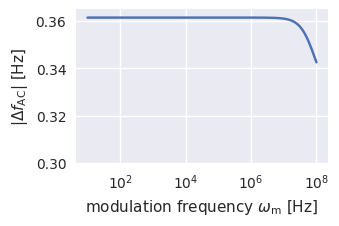

In [24]:
plotme(omega_m__array, blds(omega_m__array, 1e19,1e-8))

omega0 = 9.05e+06 Hz


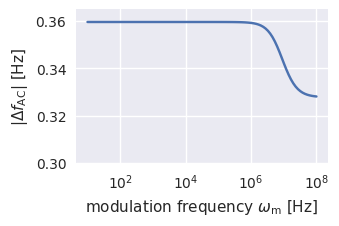

In [25]:
plotme(omega_m__array, blds(omega_m__array, 1e18,1e-8))

omega0 = 9.05e+05 Hz


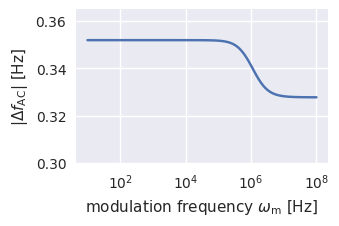

In [26]:
plotme(omega_m__array, blds(omega_m__array, 1e17,1e-8))

omega0 = 9.05e+04 Hz


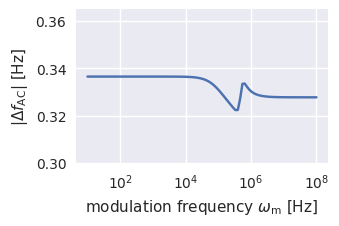

In [27]:
plotme(omega_m__array, blds(omega_m__array, 1e16,1e-8))

omega0 = 9.05e+03 Hz


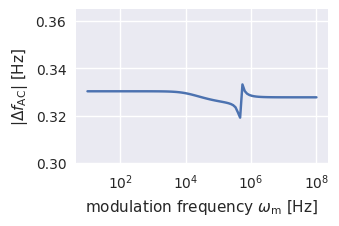

In [28]:
plotme(omega_m__array, blds(omega_m__array, 1e15,1e-8))

# Compute a BLDS spectrum "by hand"

I wonder if there is a problem with my numerical integration scheme. \
See `dissipation-theory--Study-64` for inspiration.

## Using `KmatrixIII_jit` from `dissipation13.py`

In [29]:
import scipy
from dissipationtheory.dissipation13e import KmatrixIII_jit

Create a Type III sample with a charge density of $\rho = 10^{17} \: \mathrm{cm}^{-3}$ and a charge mobility of $\mu = 10^{-8} \: \mathrm{m}^2 \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}$.  Based on the representative LDS spectrum calculations above, these parameters should give a "bumpy" spectrum.

In [30]:
rho = ureg.Quantity(1e17, '1/cm^3')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = (qe * mu * rho).to('S/m')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

Create a `pointprobeObject` with a tip-sample separation of $h = 73$ nm.

In [31]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(ureg.Quantity(73, 'nm'))
obj['pt 3'].set_breakpoints(15)

Having created a `pointprobeObject`, we now have access to the $r_k$ and $s_k$ vectors.

In [32]:
(obj['pt 3'].rk, obj['pt 3'].sj)

(array([[  0.,   0., 108.]]), array([[  0.,   0., 108.]]))

Write a stripped-down function, based on `.solve`, which computes $K_2$.

In [33]:
def calc_K2(self, omega):    
    
    j0s = scipy.special.jn_zeros(0,100.)
    an, _ = scipy.integrate.newton_cotes(20, 1)

    args = {'omega': omega, 
        'omega0': self.sample.omega0,
        'kD': self.sample.kD, 
        'es': self.sample.epsilon_s, 
        'sj': self.sj, 
        'rk': self.rk, 
        'j0s': j0s, 
        'an': an,
        'breakpoints': self.breakpoints}

    K0, K1, K2 = KmatrixIII_jit(**args)
    
    return K2[0][0]

For a trial value of $\omega_{\mathrm{m}} = 1 \times 10^{2}$, compute $K_2$.

In [34]:
calc_K2(obj['pt 3'], 1e2)

(1.9410416528550812e-07-2.4955927196765073e-11j)

We see that the `.solve()` function gives the same answer.

In [35]:
_, _, K2 = obj['pt 3'].solve(1e2)
K2

<Quantity((1.9410416528550812e-07-2.4955927196765073e-11j), '1 / nanometer ** 3')>

Now loop over the $\omega_{\mathrm{m}}$ array, and compute $K_2(\omega_{\mathrm{m}})$.

In [36]:
def calc_K2__array(omega_m__array, self):

    K2__array = np.zeros(len(omega_m__array), dtype=complex)
    
    for index, omega_m in enumerate(omega_m__array.to('Hz').magnitude):
    
        K2__array[index] = calc_K2(self, omega_m)
        
        _, _, K2 = self.solve(omega_m)
        K2__array[index] = K2.to('1/nm^3').magnitude
        
    return K2__array

Plot normalized $K_2$ versus $\omega_{\mathrm{m}}$.

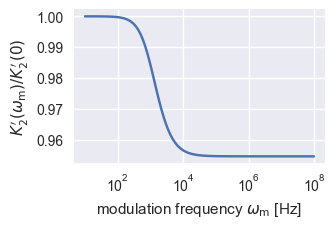

In [57]:
K2__array = calc_K2__array(omega_m__array, obj['pt 3'])

with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.25, 2.00))
    plt.semilogx(omega_m__array.to('Hz').magnitude, 
                 K2__array.real / K2__array[0].real)
    plt.xlabel(r'modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
    plt.ylabel('$K_2^{\prime}(\omega_{\mathrm{m}}) / K_2^{\prime}(0)$')
    plt.show()

The plot looks as I would expect. \
No bumps!

Conclude that `KmatrixIII_jit` and `.solve()` are probably ok.

Now make a function which computes $\Delta f_{\mathrm{AC}}$ from $K_2$, looping over $\omega_{\mathrm{m}}$ values.

In [38]:
def calc_dfac__array1(omega_m__array, self):

    K2__array = np.zeros(len(omega_m__array), dtype=complex)
    
    for index, omega_m in enumerate(omega_m__array.to('Hz').magnitude):
    
        K2__array[index] = calc_K2(self, omega_m)
        
    wc = self.sample.cantilever.omega_c
    wc_units = ureg.Quantity(self.sample.cantilever.omega_c, 'Hz')

    Vc = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
    fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')   
    Rc = ureg.Quantity(self.sample.cantilever.R, 'm')
    
    C0 = 4 * np.pi * epsilon0 * Rc
    q0 = C0 * Vc
    
    dfac = - (fc * q0**2 * ureg.Quantity(K2__array.real, '1/nm^3')) / \
             (8 * np.pi * epsilon0 * kc)
    
    return dfac.to('Hz').magnitude

Spot-check the frequency-shift result at one $\omega_{\mathrm{m}}$.

In [39]:
calc_dfac__array1(omega_m__array[0:1], obj['pt 3'])

array([-0.35432579])

Compare to the `.properties()` function calculation.

In [40]:
obj['pt 3'].properties(
    omega_m__array[0:1].to('Hz').magnitude[0]
)
obj['pt 3'].results['Delta f ac [Hz]']

-0.3519052774292884

The frequency shifts are similar but not identical. This difference could be due to the `.properties()` calculation including three terms in $\Delta f_{\mathrm{AC}}$, or it could be due to a bug.

Plot $\Delta f_{\mathrm{AC}}$ versus $\omega_{\mathrm{m}}$.

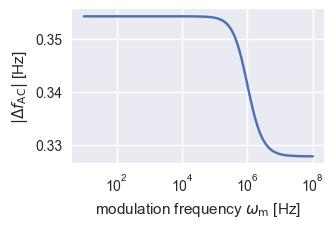

In [41]:
dfac__array = calc_dfac__array1(omega_m__array, obj['pt 3'])

with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.25, 2.00))
    plt.semilogx(omega_m__array.to('Hz').magnitude, 
                 np.abs(dfac__array))
    plt.xlabel(r'modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
    plt.ylabel('$|\Delta f_{\mathrm{AC}}|$ [Hz]')
    plt.show()

Nice looking ... no bump!

The problem must be with the `.properties()` function. \
This function was called by my `blds` function above.

omega0 = 9.05e+05 Hz


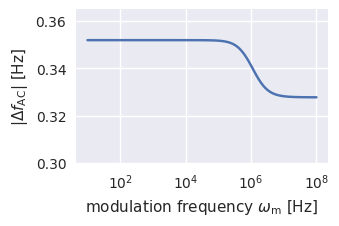

In [42]:
plotme(omega_m__array, blds(omega_m__array, 1e17, 1e-8))

The next step is to reproduce the `.properties` function here, to make it easier to debug.  Reproduce the `.properties()` function from the `pointprobeCobject()` object in `dissipationtheory17e.py` below. Leave out the `print` function and the two `self.keys +=` statements at the end of the function.  Rename the function, calling it `properties1`. 

In [43]:
def properties1(self, omega_m):
    
    """Compute the friction when a DC voltage is applied to the cantilever.
    Compute the cantilever friction and frequency shift when 
    DC and AC voltages are applied to the cantilever.  Here omega_m
    is the unitless voltage-modulation frequency."""

    # Compute friction and dc frequency shift

    wc = self.sample.cantilever.omega_c
    wc_units = ureg.Quantity(self.sample.cantilever.omega_c, 'Hz')

    _, _, K2wc = self.solve(wc)
    _, _, K2dc = self.solve(0.)

    Vc = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
    fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')   
    Rc = ureg.Quantity(self.sample.cantilever.R, 'm')

    C0 = 4 * np.pi * epsilon0 * Rc
    q0 = C0 * Vc

    gamma = - (q0**2 * K2wc.imag)/(8 * np.pi * epsilon0 * wc_units)

    dK2wc = K2wc - K2dc
    Kterms = K2dc + 0.25 * dK2wc

    dfdc = - (fc * q0**2 * Kterms.real)/(4 * np.pi * epsilon0 * kc)

    # Compute ac frequency shift

    wp = wc + omega_m
    wm = wc - omega_m

    _, _, K2wm = self.solve(omega_m)
    _, _, K2wp = self.solve(np.abs(wp))
    _, _, K2wm = self.solve(np.abs(wm))

    dK2wp = K2wp - K2dc
    dK2wm = K2wm - K2dc

    Kterms = K2wm.real  + 0.25 * wc * (dK2wp.real / wp + dK2wm.real / wm)

    dfac = - (fc * q0**2 * Kterms)/(8 * np.pi * epsilon0 * kc)

    self.results['C0 [aF]'] = C0.to('aF').magnitude
    self.results['q0/qe'] = (q0/qe).to('').magnitude
    self.results['gamma [pN s/m]'] = gamma.to('pN s/m').magnitude
    self.results['Delta f dc [Hz]'] = dfdc.to('Hz').magnitude
    self.results['Delta f ac [Hz]'] = dfac.to('Hz').magnitude

Verify that we get the same results as above.

In [44]:
properties1(
    obj['pt 3'], omega_m__array[0:1].to('Hz').magnitude[0]
)
obj['pt 3'].results['Delta f ac [Hz]']

-0.3470644093464442

Now rewrite the `blds` function, call is `blds1`, to use this stand-alone `properties1` function instead of the build-in `properties` function.  To avoid duplication of code below, write the function that accepts a variable property-calculating function.

In [45]:
def blds_new(omega_m__array, rho, mu, properties):

    rho = ureg.Quantity(rho, '1/cm^3')
    mu = ureg.Quantity(mu, 'm^2/(V s)') 
    sigma = (qe * mu * rho).to('S/m')

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    print(f"omega0 = {sample3_jit.omega0/sample3_jit.epsilon_s.real:0.2e} Hz")

    dfac__array = np.zeros(len(omega_m__array))

    obj['pt 3'] = pointprobeCobject(sample3_jit)
    obj['pt 3'].addsphere(h)
    obj['pt 3'].set_breakpoints(15)

    for index, omega_m in enumerate(omega_m__array):

        properties(obj['pt 3'], omega_m.to('Hz').magnitude)    
        dfac__array[index] = obj['pt 3'].results['Delta f ac [Hz]']
        
    return dfac__array

We get the same puzzling result.

omega0 = 9.05e+05 Hz


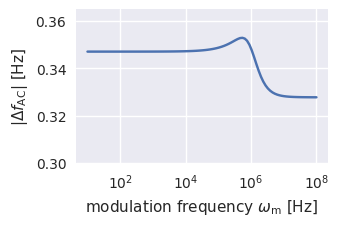

In [46]:
plotme(omega_m__array, blds_new(omega_m__array, 1e17, 1e-8, properties1))

Ok, now make a stripped-down version of the `properties` function, call it `properties2`.

In [47]:
def properties2(self, omega_m):
    
    wc = self.sample.cantilever.omega_c
    
    Vc = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
    fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')   
    Rc = ureg.Quantity(self.sample.cantilever.R, 'm')

    q0 = 4 * np.pi * epsilon0 * Rc * Vc

    w_plus = wc + omega_m
    w_minus = wc - omega_m

    _, _, K2dc = self.solve(0.)
    _, _, K2wm = self.solve(omega_m)
    # _, _, K2wm = self.solve(np.abs(wm)) <== I'm re-using the same variable name!
    _, _, K2w_plus = self.solve(w_plus)
    _, _, K2w_minus = self.solve(np.abs(w_minus))

    dK2w_plus = K2w_plus - K2dc
    dK2w_minus = K2w_minus - K2dc
        
    Kterms = K2wm.real + 0.25 * wc * \
        (dK2w_plus.real / w_plus + dK2w_minus.real / w_minus)

    dfac = - (fc * q0**2 * Kterms)/(8 * np.pi * epsilon0 * kc)

    self.results['Delta f ac [Hz]'] = dfac.to('Hz').magnitude

Plot the computed frequency shift.

At $\rho = 10^{17} \: \mathrm{cm}^{-13}$ the LDS spectrum now looks reasonable.

omega0 = 9.05e+05 Hz


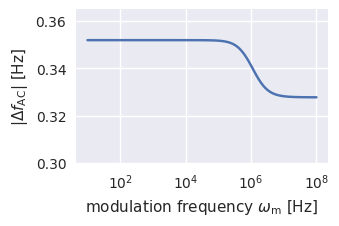

In [48]:
plotme(omega_m__array, blds_new(omega_m__array, 1e17, 1e-8, properties2))

Ok, go back and fix the code in `dissipationtheory17e.py`.

At $\rho = 10^{16} \: \mathrm{cm}^{-13}$, however, the LDS spectrum has a funny kink.

omega0 = 9.05e+04 Hz


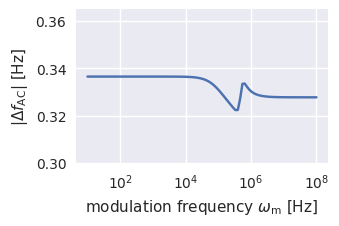

In [49]:
plotme(omega_m__array, blds_new(omega_m__array, 1e16, 1e-8, properties2))

The funny kink is due to $\omega_{\mathrm{m}} \sim \omega_{\mathrm{c}}$ and not $\omega_{\mathrm{m}} \sim \omega_0$.  

We can show this by reducing the mobility $\mu$ from $10^{-8} \: \mathrm{m}^2 \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}$ to $10^{-10} \: \mathrm{m}^2 \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}$, lowering $\omega_0$ by a factor of $10^{2}$.

omega0 = 9.05e+02 Hz


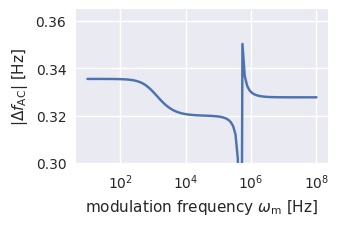

In [50]:
plotme(omega_m__array, blds_new(omega_m__array, 1e16, 1e-10, properties2))

This LDS spectrum is still problematic.

* There is a well behaved rolloff near $\omega_0 = 9.1 \times 10^{2} \: \mathrm{Hz}$. Above the roll-off, however, $\Delta f_{\mathrm{AC}}$ is *below* high-frequency limit.

* There is a kink in the spectrum near $\omega_{\mathrm{c}} = 4.7 \times 10^{5} \: \mathrm{Hz}$.  For $\omega_{\mathrm{m}} \ll \omega_{\mathrm{c}}$, $\Delta f_{\mathrm{AC}}$ is *below* the high-frequency limit.  For $\omega_{\mathrm{m}} \gg \omega_{\mathrm{c}}$, $\Delta f_{\mathrm{AC}}$ approaches the high-frequency limit.

In summary, for $\omega_0 < \omega_{\mathrm{m}} < \omega_{\mathrm{c}}$, the frequency shift appears anomalous.

Is the problem due to the second and third terms?

Perform a $\Delta f_{\mathrm{AC}}$ calculation using just the first term.

In [51]:
def properties3(self, omega_m):

    wc = self.sample.cantilever.omega_c
    
    Vc = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
    fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')   
    Rc = ureg.Quantity(self.sample.cantilever.R, 'm')

    q0 = 4 * np.pi * epsilon0 * Rc * Vc

    w_plus = wc + omega_m
    w_minus = wc - omega_m

    _, _, K2wm = self.solve(omega_m)
        
    Kterms = K2wm.real

    dfac = - (fc * q0**2 * Kterms)/(8 * np.pi * epsilon0 * kc)

    self.results['Delta f ac [Hz]'] = dfac.to('Hz').magnitude

Using the first term alone gives a reasonable LDS spectrum.

omega0 = 9.05e+02 Hz


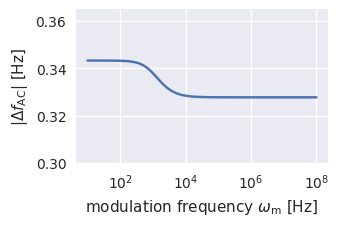

In [52]:
plotme(omega_m__array, blds_new(omega_m__array, 1e16, 1e-10, properties3))

So the second and third terms, the Berne and Frisch terms, are problematic.

Write a function that computes the three terms separately. \
The *sign* each term is important, so do not take the absolute value. \
Have this function loop over an array of $\omega_{\mathrm{m}}$ values.

In [140]:
def properties4(self, omega_m__array):
    
    wc = self.sample.cantilever.omega_c
    
    Vc = ureg.Quantity(self.sample.cantilever.V_ts, 'V')
    fc = ureg.Quantity(self.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(self.sample.cantilever.k_c, 'N/m')   
    Rc = ureg.Quantity(self.sample.cantilever.R, 'm')

    q0 = 4 * np.pi * epsilon0 * Rc * Vc

    
    dfac = np.zeros((3, len(omega_m__array)))
    for index, omega_m in enumerate(omega_m__array.to('Hz').magnitude):
    
        w_plus = wc + omega_m
        w_minus = wc - omega_m

        _, _, K2dc = self.solve(0.)
        _, _, K2wm = self.solve(omega_m)
        _, _, K2w_plus = self.solve(w_plus)
        _, _, K2w_minus = self.solve(np.abs(w_minus))

        dK2w_plus = K2w_plus - K2dc
        dK2w_minus = K2w_minus - K2dc

        Kterm1 = K2wm.real
        Kterm2 = 0.25 * wc * dK2w_plus.real / w_plus 
        Kterm3 = 0.25 * wc * dK2w_minus.real / w_minus       
        
        dfac1 = - ((fc * q0**2 * Kterm1)/(8 * np.pi * epsilon0 * kc)).to('Hz').magnitude
        dfac2 = - ((fc * q0**2 * Kterm2)/(8 * np.pi * epsilon0 * kc)).to('Hz').magnitude
        dfac3 = - ((fc * q0**2 * Kterm3)/(8 * np.pi * epsilon0 * kc)).to('Hz').magnitude

        dfac[:,index] = np.array([dfac1, dfac2, dfac3])
    
    return dfac

Make a utility function to create a `pointprobeCobject` at height $h$ for a Type III sample with a given charge denstiy `rho` and mobility `mu`.

In [182]:
def create_obj(rho, mu):

    rho = ureg.Quantity(rho, '1/cm^3')
    mu = ureg.Quantity(mu, 'm^2/(V s)') 
    sigma = (qe * mu * rho).to('S/m')

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    obj = pointprobeCobject(sample3_jit)
    obj.addsphere(h)
    obj.set_breakpoints(15)
        
    print(f"   rho = {rho.to('cm^{-3}').magnitude:0.2e} cm^{-3}")
    print(f"    mu = {mu.to('cm^2/(V s)').magnitude:0.2e} cm^2/(V s)")
    print(f" sigma = {sigma.to('S/cm').magnitude:0.2e} S/cm")
    print(f"omega0 = {sample3.omega0/sample3.epsilon_s.real:0.2e} Hz")
        
    return obj

Plot the three terms, taking care to make the $y$-axis range the same for all three terms so we can compare them. 

In [183]:
x = omega_m__array.to('Hz').magnitude
y1, y2, y3 = properties4(create_obj(1e16, 1e-10), omega_m__array)

def plotthis(x, y1, y2, y3):

    with plt.style.context('seaborn-v0_8'):

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8.5, 2.5), sharex=True)
        axes[0].semilogx(x, np.abs(y1 + y2 + y3), 'k-')
        axes[0].set_ylim([0.31, 0.34])
        axes[0].set_title('$|\Delta f_{\mathrm{AC}}|$ [Hz] (total)', fontsize=10)
        axes[1].semilogx(x, y1)
        axes[1].set_ylim([-0.35, -0.32])
        axes[1].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 1)', fontsize=10)
        axes[2].semilogx(x, y2)
        axes[2].set_ylim([-0.015, 0.015])
        axes[2].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 2)', fontsize=10)
        axes[3].semilogx(x, y3)
        axes[3].set_ylim([-0.015, 0.015])
        axes[3].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 3)', fontsize=10)
        for n in range(4):
            axes[n].set_xlabel(r'$\omega_{\mathrm{m}}$ [Hz]')
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.40)
        
        return fig

   rho = 1.00e+16 cm^-3
    mu = 1.00e-06 cm^2/(V s)
 sigma = 1.60e-09 S/cm
omega0 = 9.05e+02 hertz Hz


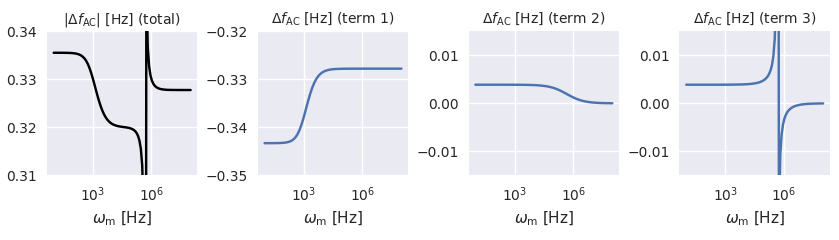

In [171]:
figs['04'] = plotthis(x, y1, y2, y3)
figs['04']

We can estimate the size of th second and third terms at low $\omega_{\mathrm{m}}$

In [185]:
0.25 * (-0.3275+0.3450)

0.00437499999999999

which is in reasonable agreementn with what I see in the above plots.

Now plot the $\Delta f_{\mathrm{AM}}$ spectrum for one of the cases with higher $\rho$ and $\mu$.

   rho = 1.00e+16 cm^-3
    mu = 1.00e-03 cm^2/(V s)
 sigma = 1.60e-06 S/cm
omega0 = 9.05e+05 hertz Hz


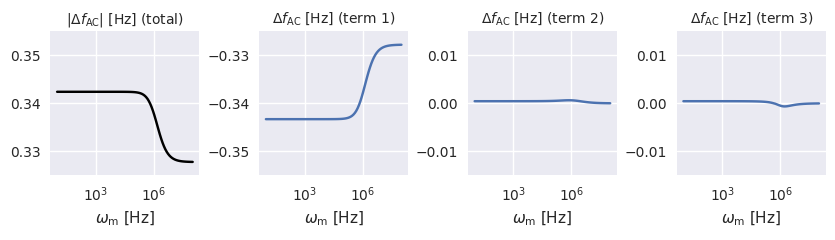

In [186]:
x = omega_m__array.to('Hz').magnitude
y1, y2, y3 = properties4(create_obj(1e16, 1e-7), omega_m__array)

def plotthis(x, y1, y2, y3):

    with plt.style.context('seaborn-v0_8'):

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8.5, 2.5), sharex=True)
        axes[0].semilogx(x, np.abs(y1 + y2 + y3), 'k-')
        axes[0].set_ylim([0.325, 0.355])
        axes[0].set_title('$|\Delta f_{\mathrm{AC}}|$ [Hz] (total)', fontsize=10)
        axes[1].semilogx(x, y1)
        axes[1].set_ylim([-0.355, -0.325])
        axes[1].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 1)', fontsize=10)
        axes[2].semilogx(x, y2)
        axes[2].set_ylim([-0.015, 0.015])
        axes[2].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 2)', fontsize=10)
        axes[3].semilogx(x, y3)
        axes[3].set_ylim([-0.015, 0.015])
        axes[3].set_title('$\Delta f_{\mathrm{AC}}$ [Hz] (term 3)', fontsize=10)
        for n in range(4):
            axes[n].set_xlabel(r'$\omega_{\mathrm{m}}$ [Hz]')
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.40)
        
        return fig

figs['03'] = plotthis(x, y1, y2, y3)
figs['03']

A summary of simulation parameters for Figure 03 and Figure 04.

| parameter | symbol | Fig 3 value |  Fig 4 value | unit |
| --------: | :------ |  ----: | ----: | :--- |
|
| tip radius | $R$ | $35$ | $35$ | $\mathrm{nm}$ |
| tip-sample separation | $h$ | $73$ | $73$ | $\mathrm{nm}$ |
| tip voltage | $V_0$ | $1$ | $1$ | $\mathrm{V}$ |
|
| sample type | -- | III | III | -- |
| dielectric constant | $\epsilon_{\mathrm{s}}$ | $$20.0 - 0.2 j$$ | $$20.0 - 0.2 j$$ | -- |
| charge density | $\rho$ | $10^{16}$ | $10^{16}$ | $\mathrm{cm}^{-3}$ |
| charge mobility | $\mu$ | $10^{-3}$ | $10^{-6}$ | $\mathrm{cm}^2 \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}$ | 
| conductivity | $\sigma$ | $1.6 \times 10^{-6}$ | $1.6 \times 10^{-9}$ | $$\mathrm{S} \: \mathrm{m}^{-1}$$ | 
| charge frequency | $\omega_0$ | $9.1 \times 10^{5}$ | $9.1 \times 10^{2}$ | $\mathrm{Hz}$ |

In this case the Berne and Frisch terms are basically negligible.

## Using `K_jit` from `dissipation9b.py`

Put off this calculation for now.

::: {.content-hidden when-format="html"}

In [146]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  During development you can run the following command to render and display an `html` file on the fly.

    quarto preview dissipation-theory--Study-73.ipynb

When you are done developing this notebook, run  `quarto` from the command line as follows to create a nicely-formated `.html` version of the notebook.

    quarto render dissipation-theory--Study-73.ipynb && open dissipation-theory--Study-73.html
    
:::